In [2]:
import pandas as pd
import numpy as np
import scipy.sparse as ss
import pickle

from sklearn.feature_extraction.text import CountVectorizer

from corextopic import corextopic as ct
from corextopic import vis_topic as vt

import seaborn as sns
import matplotlib.pyplot as plt

import topic_modeling as tm

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df = pd.read_csv("../Reviews_cleaned_for_NLP.csv")
df.columns

Index(['attraction_name', 'attraction_id', 'user_name', 'user_profile_link',
       'review_date', 'helpful_votes', 'rating', 'review_link', 'review_text',
       'review_title', 'experience_date', 'reviews_basic_clean',
       'review_lemma', 'review_remove_stop_words',
       'review_remove_additional_words', 'review_pos_ent_filter',
       'Outlook_Sentiment', 'outlook_sentiment_number'],
      dtype='object')

### Vectorizer
The cleaned corpus is used for for creating a bag of words with TF-IDF
This will then be used for topic modeling.

In [84]:
df['review_clean_modeling'] = df['review_remove_additional_words']
topics_list = []

In [74]:
vectorizer = CountVectorizer(max_features=20000, min_df = 10, max_df = 0.5, ngram_range = (1, 2), binary=True)

doc_word = vectorizer.fit_transform(df.review_clean_modeling)
words = list(np.asarray(vectorizer.get_feature_names()))

doc_word.shape

(10725, 5472)

### Topic Modeling Using Corex
**Note**: Prior to this, topic modeling was tried using NMF & LDA. But these algorithms did not yield the desired optimial results.

In [141]:
topic_model = ct.Corex(n_hidden=25, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs = df.review_text)

topic_model.tc

12.57988909906476

In [66]:
# Print a single topic from CorEx topic model
topic_model.get_topics(topic=11, n_words=10)

[('spend', 0.11076850275510405),
 ('day', 0.059936227519525424),
 ('shop', 0.053432243650766),
 ('visitor', 0.04250712545845151),
 ('gift', 0.03710155219179291),
 ('gift shop', 0.035207706606604695),
 ('ranger', 0.030100408820825743),
 ('center', 0.030067707239215154),
 ('visitor center', 0.029916602679831462),
 ('wait', 0.029352227151842693)]

In [67]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: mist, step, mist trail, muir, john muir, john, muir trail, steep, wet, slippery
1: tree, grove, giant, sequoia, mariposa, mariposa grove, tram, giant sequoia, grizzly, grizzly giant
2: half dome, dome, half, el, capitan, el capitan, tioga, tioga pass, lake, view half
3: fall, water, yosemite fall, falls, low, low fall, upper, bridge, flow, dry
4: cable, permit, glove, bring, sub dome, sub, need, lottery, shape, height
5: point, glacier point, glacier, drive glacier, view glacier, point view, vantage point, vantage, sentinel dome, sentinel
6: vernal, vernal fall, nevada, nevada fall, nevada falls, round trip, round, hike vernal, vernal nevada, trail vernal
7: drive, park, national, national park, road, yosemite national, car, yosemite, car park, worth drive
8: parking, early, shuttle, parking lot, bus, morning, early morning, shuttle bus, crowd, free
9: start, people, elevation, gain, break, switchback, trailhead, elevation gain, hiker, rock
10: trail, trail not, mile trail, fall tra

In [68]:
topic_model.get_top_docs(topic = 1)

[('You will feel as if you are in the Jurassic park.Yosemite is a must visit place .A visit of lifetime.When the tram tour was taking us thru the mariposa grove the feelings was indescribable.Some tree trunks are as wide as a bungalow. Some trunks caught fire and a huge tree cave is formed A  big truck can also pass thru the trunk',
  0.0),
 ("Well worth the time if you are entering/exiting Yosemite through this entrance.  The easy but uphill walk to the lower grove is marked with information signs, also use the pamphlet for more information.  You will see a couple of the larger sequoia trees, but they are just a taste of what can be seen in King's Canyon and Sequoia National Parks.  We didn't have time to walk all the way to the upper grove area, but other visitors used the tram.",
  0.0),
 ("My family was fortunate enough to visit Yosemite right after the Mariposa Grove reopened to visitors and we enjoyed it so much. The trees are spectacular and not like anything I've seen before. T

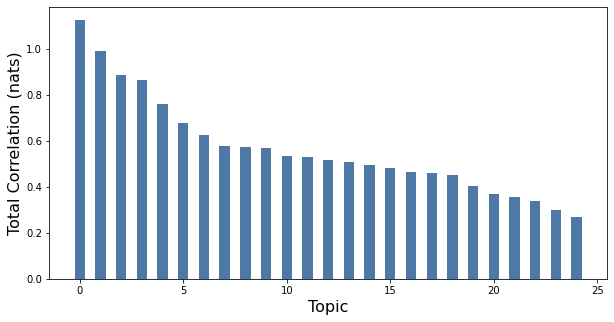

In [118]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.show()

Using the above results as an initial sample, **anchor words** are used to create topic groupings in a semi-supervised manner.  
  
The final resulting anchor words seen below was obtained over 20+ iterations.

In [75]:
anchor_words = [['amazing', 'view', 'awe', 'inspire'], \
                ['not miss','definite', 'visit', 'recommend visit', 'highly recommend', 'bucket list'], ['photo'], \
                ['strenous', 'not easy', 'strenuous', 'strenuous hike', 'steep hike', 'steep', 'steep climb'],\
                ['easy hike', 'short hike', 'easy walk', 'short walk', 'walk trail' ], ['sunset'], \
                ['waterfall', 'fall', 'falls'], ['lake',], ['wildlife' , 'animal', 'cub', 'bear cub'],   \
                ['night', 'sky', 'star', 'night sky'], \
                ['shuttle', 'bus', 'shuttle stop', 'bus stop', ], ['tour bus', 'bus tour', 'tram' ,'tram ride'],  \
                ['permit', 'lottery'], ['bring', 'water'], ['rock climb', 'cable climb', ], ]

topic_model_anc = ct.Corex(n_hidden=18, words=words, seed=1)
topic_model_anc.fit(doc_word, words=words, docs = df.review_text, anchors = anchor_words, anchor_strength = 4)
print(topic_model_anc.tc)
print(topic_model_anc.tcs)

# Below are topics that would have been great to have so as to be able to provide users information on them,
# but did not result in great topics when using them as anchor words.
desired_topics = [['eat' , 'food', 'cafe'], ['scenic drive', 'driving'],]

24.752483141330426
[2.59431148 1.56268669 1.04549437 2.04265816 0.83278908 0.85630762
 2.97898354 1.03292697 0.9378605  0.98544541 1.50691793 1.06472115
 1.43908596 2.16787621 1.50722335 0.50601261 0.8805779  0.81060419]


In [ ]:
# Saving the corex model as a pickle file
with open ("corex_topic_model_anchor.pkl", "wb") as model:
    pickle.dump(topic_model_anc, model)

In [77]:
# Print all topics from the CorEx topic model to ascertin their topics
topics = topic_model_anc.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))
    try:
        print(f"Anchore Words: {anchor_words[n]}")
    except:
        print("No more anchor words")
    print(f"TC Score: {topic_model_anc.tcs[n]}")    
    for each_doc in topic_model_anc.get_top_docs(topic = n, n_docs=5):
        print("Review: ", each_doc[0])
    print("\n")

0: view, great view, inspire, amazing view, good view, amazing, beautiful view, spectacular view, view amazing, view spectacular
Anchore Words: ['amazing', 'view', 'awe', 'inspire']
TC Score: 2.594311481890592
Review:  Not too many ppl when we arrive at 3pm, probably because they are controlling visitor per day in national park. Smoke was not crazy today, view was okay. -Oct 16 2020
Review:  Maybe you've seen lots of photos of Tunnel View. It's not possible to imagine how breathtaking it is until you cross the tunnel and stop to stare this dramatic view of the valley.
Review:  What a view....I could stand there for hours!!!Easy to find, easy to park...Plenty of space to walk around and take your pictures (don't forget your tripod)!You have almost everything in front of you (Half- Dome,Bridalveil fall, El Capitan)!!!
Review:  Immediately upon exiting the tunnel you're presented with this stunning location and view of the Yosemite valley. There's a small car park available and specific p

By analyzing the above results, following are the labels for the 18 topics obtained.

In [ ]:
topics = ['Breathtaking Views', 'Must Visits', 'Panaromic Photography', 'Strenuous Hikes', 'Easy Trails', 'Gorgeous Sunsets', 
          'Stunning Waterfalls', 'Serene Lakes', 'Wildlife',  'Stargazing', 'Shuttle Bus', 'Organized Tours',
          'Permit Restrictions',    'Water Advice','Rock Climbing', 'Climbing Advice', 'General Advice', 'Hiking Advice']

In [80]:
# Creating a dataframe with the topics as columns and documents as rows, with Binary values indicating whether the given document 
# belongs in the respective topic

predictions = pd.DataFrame(topic_model_anc.predict(doc_word), columns=topics)

# % of documents present in each topic
predictions.sum(axis=0)/len(predictions) * 100

Breathtaking Views       43.524476
Must Visits              21.351981
Panaromic Photography     7.720280
Strenuous Hikes          16.820513
Easy Trails              12.606061
Gorgeous Sunsets         33.081585
Stunning Waterfalls      34.526807
Serene Lakes             15.375291
Wildlife                 16.317016
Stargazing               13.724942
Shuttle Bus              11.421911
Organized Tours          12.027972
Permit Restrictions       8.121212
Water Advice             19.636364
Rock Climbing            13.557110
Climbing Advice          21.277389
General Advice           24.578089
Hiking Advice            19.160839
dtype: float64

Looking at the above doc % for each topic, we can be confident that the topics are meaningful, as each of them have a non-trivial number of documents belonging to them.

In [94]:
# Saving the outputs for further analysis, visualization & recommendation system

df = df.join(pd.DataFrame(topic_model_anc.p_y_given_x, columns = topics))

df.to_csv('Reviews_with_topic_scores.csv', index=False)

df_preds = df.drop(columns = topics).join(predictions)

df_preds.to_csv("Reviews_with_topic_presence.csv", index=False)